In [3]:
%pip install phiflow
from phi.jax.flow import *
from phi.flow import *  # If JAX is not installed. You can use phi.torch or phi.tf as well.
from tqdm.notebook import trange
from functools import partial

In [4]:
math.set_global_precision(64)  # double precision for all following operations

In [5]:
domain = dict(x=25, y=25, boundary=PERIODIC, bounds=Box(x=2*PI, y=2*PI))
viscosity = 0.3

In [6]:
def taylor_green_velocity(x, t):
    sin_x, sin_y = math.sin(x).vector
    cos_x, cos_y = math.cos(x).vector
    return vec(x=cos_x*sin_y, y=-sin_x*cos_y) * math.exp(-2 * viscosity * t)

def taylor_green_pressure(x, t):
    return -1 / 4 * (math.sum(math.cos(2 * x), 'vector')) * math.exp(-4 * viscosity * t)

In [7]:
time = math.linspace(0, 10., batch(time=200))
analytic_v = StaggeredGrid(partial(taylor_green_velocity, t=time), **domain)
analytic_p = CenteredGrid(partial(taylor_green_pressure, t=time), **domain)

In [8]:
plot({"Velocity": analytic_v.time[::4], "Pressure": analytic_p.time[::4]}, animate='time', same_scale=False)

<Figure size 640x480 with 0 Axes>

In [7]:
@jit_compile
def step(velocity, pressure, dt):
  velocity = diffuse.explicit(velocity, viscosity, dt)
  velocity = advect.semi_lagrangian(velocity, velocity, dt)
  return fluid.make_incompressible(velocity, (), Solve('CG', 1e-12, 1e-12, x0=pressure))

dt = time.time[1] - time.time[0]
v0, p0 = analytic_v.time[0], analytic_p.time[0]
sim_v, sim_p = iterate(step, time.shape-1, v0, p0, dt=dt)

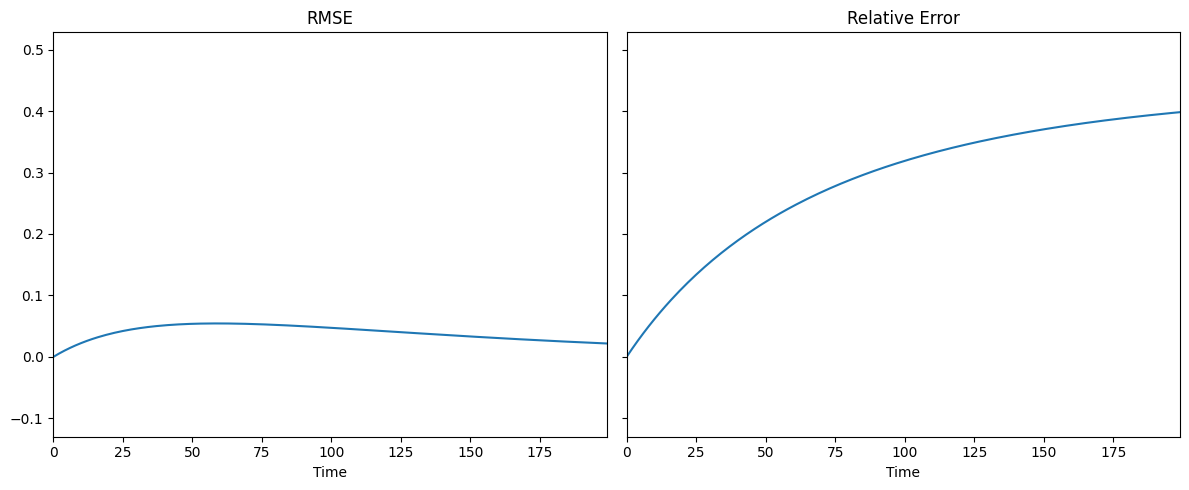

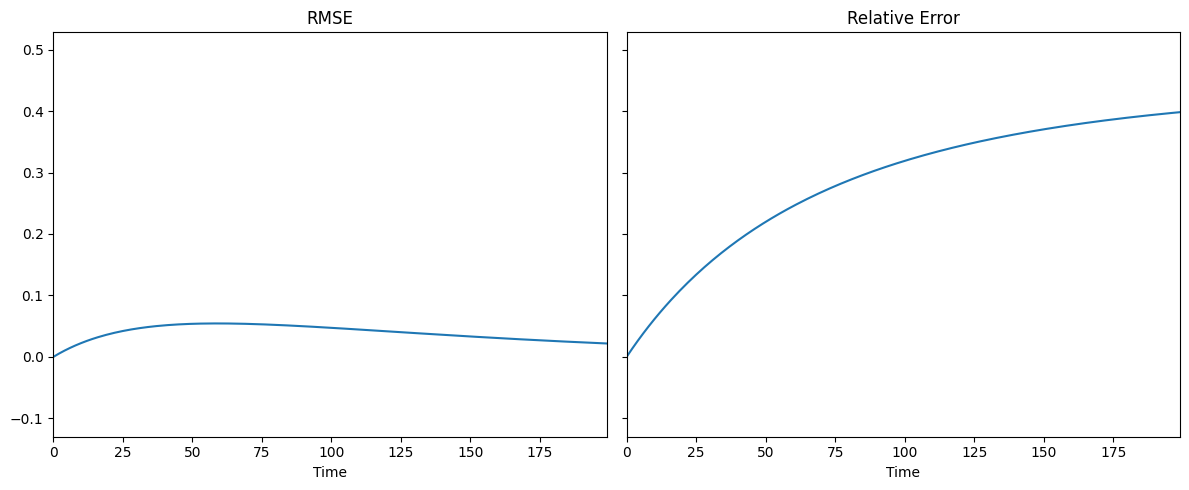

In [8]:
rmse = math.sqrt(math.mean((analytic_v - sim_v).values**2))
relative_err = rmse / math.mean(abs(analytic_v.values))
plot({"RMSE": rmse.time.as_spatial(), "Relative Error": relative_err.time.as_spatial()})